# Construyendo una red neuronal con Keras

**Autor**: Arturo Sánchez Palacio

Basado en: https://github.com/lazyprogrammer

**Fecha de última revisión: 18/I/2020**

Como siempre comenzamos instalando los módulos que necesitamos e importándolos:

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Keras está optimizado para trabajar con enormes tamaños de datos por lo que en este caso trabajaremos con la base de datos __completa__:

In [2]:
df = pd.read_csv('./data/preprocessed_rating.csv')

Calculamos el número total de usuarios y películas:

In [3]:
N = df.userId.max() + 1
M = df.movie_idx.max() + 1

#### To do. Como es habitual en los procesos de Machine Learning dividimos en entrenamiento y test. En este caso fijamos el tamaño de entrenamiento al 80%:

In [4]:
df = shuffle(df)
umbral = int(0.8*len(df))
df_train = df.iloc[:umbral]
df_test = df.iloc[umbral:]

Inicializamos las variables habituales:

In [5]:
K = 10 # dimension latente
mu = df_train.rating.mean() #media global
iteraciones = 15 
reg = 0.0001 # coeficiente de regularización

Ya hemos fijado las bases para construir el modelo. Importamos los tipos de capas que vamos a usar:

In [6]:
from keras.layers import Input, Embedding, Flatten

Using TensorFlow backend.


#### To do. Empezamos creando las capas de entrada:

In [7]:
u = Input(shape=(1,)) # escalar del usuario
m = Input(shape=(1,)) # escalar de la película

#### To do. Realizamos el embedding del vector de usuario y de película en las matrices:

In [8]:
from keras.regularizers import l2
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u) # dimensión: (N, 1, K)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m) # dimensión: (N, 1, K)

__Nota.__ Aquí es donde empieza a modificarse respecto al anterior.

Aplanamos los embeddings:

In [9]:
u_embedding = Flatten()(u_embedding) # dimensión: (N, K)
m_embedding = Flatten()(m_embedding) # dimensión: (N, K)

#### To do .Una vez aplanados es posible concatenarlos:

In [10]:
from keras.layers import Concatenate
x = Concatenate()([u_embedding, m_embedding]) # dimensión: (N, 2K)

Una vez hecho esto se procede a construir la arquitectura del modelo neuronal. Este modelo puede ser tan complicado y denso como se quiera. En el ejemplo planteamos uno bastante sencillo para que se entrene en poco tiempo:

In [11]:
from keras.layers import Dense, Activation
x = Dense(400)(x) #Simplemente tiene 400 neuronas
x = Activation('relu')(x) #Te puede devolver cualquier valor, no valores acotados
x = Dense(1)(x) #Una neurona, fuerza una salida

Una vez planteada la arquitectura del modelo el procedimiento es análogo al del Notebook anterior. 

#### To do. Instanciamos el modelo:

In [12]:
from keras.models import Model
model = Model(inputs=[u, m], outputs=x)

Compilamos el modelo:

In [13]:
from keras.optimizers import SGD #Stochastic Gradient Descent
model.compile(
  loss='mse',#usamos como función de pérdida el error medio cuadrático
  optimizer=SGD(lr=0.08, momentum=0.9), #usamos como optimizador SGD con learning rate 0.08 y momentum 0.9
  metrics=['mse'], #empleamos como métric a el error medio cuadrático
)

Este es el modelo construido:

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        1384930     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 10)        267440      input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 

Nuestro modelo ya está listo para ser entrenado:

In [ ]:
r = model.fit(
  x=[df_train.userId.values, df_train.movie_idx.values], #variables de entrada
  y=df_train.rating.values - mu, #etiquetas a predecir
  epochs=iteraciones,
  batch_size=128, #tamaño del batch
  validation_data=([df_test.userId.values, df_test.movie_idx.values],  df_test.rating.values - mu) #datos de validacion
)



Train on 16000210 samples, validate on 4000053 samples
Epoch 1/15
 1421056/16000210 [=>............................] - ETA: 59:44 - loss: 0.9588 - mean_squared_error: 0.8692

El objeto r almacena en su historia las pérdidas a lo largo del entrenamiento y podemos tanto observarlas como representarlas:

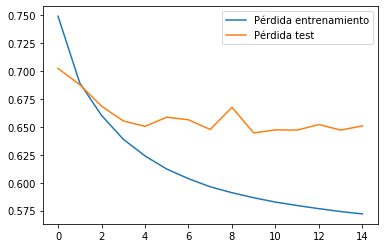

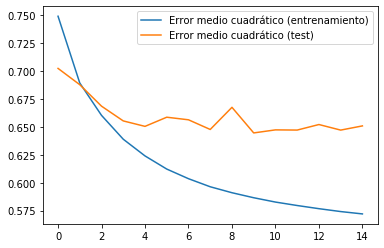

In [18]:
# plot losses
plt.plot(r.history['loss'], label="Pérdida entrenamiento")
plt.plot(r.history['val_loss'], label="Pérdida test")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mse'], label="Error medio cuadrático (entrenamiento)")
plt.plot(r.history['val_mse'], label="Error medio cuadrático (test)")
plt.legend()
plt.show()

## Conclusión

Este modelo plantea dos ventajas principales:

* Es muy fácilmente escalable. La red neuronal se puede complicar o simplifcar según nuestras necesidades de manera extremadamente sencilla. (Simplemente añadir o quitar capas).

* Trabaja con los datos sin procesar, no requiere preprocesamiento más allá que el realizado para ahorrar espacio.

Esta red es además algo más rápida que la anterior y devuelve resultados muy similares.

Si mejoráramos la red debería obtener mejores resultados que la factorización matricial por ser esta lineal mientras que la red neuronal tiene capacidad para detectar y aprender patrones no lineales.

__Nota importante.__ El modelo presentado es muy sencillo con fines didácticos (no complicarse si hay personas que no tiene un alto nivel de Deep Learning). Si al leer esto tienes un conocimiento suficiente de Deep Learning no dudes en añadir capas como DropOut BatchNormalization...